In [1]:
# !pip install kaggle
# !pip install -U torchmetrics

In [2]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets list

In [4]:
# Загрузка датасета соревнования
# !kaggle competitions download -c journey-springfield

# Распаковка и удаление архива
# %%capture
# !unzip journey-springfield.zip -d ~/Documents/datasets/journey_springfield/
# !rm journey-springfield.zip

# Journey to Springfield
[Competition Kaggle](https://www.kaggle.com/competitions/journey-springfield)


**Цель проекта:** обучить классификатор на основе сверточных нейронных сетей, чтобы научиться отличать всех жителей Спрингфилда.

Метрикой в этом соревновании является **F1 score**.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler

import torchvision
from torchvision.transforms import v2
from torchvision import models

from torchmetrics import F1Score
from torchinfo import summary

sns.set_style('whitegrid')

In [6]:
class Ansi:
    green = '\033[32m'
    red = '\033[31m'
    bold = '\033[1m'
    underline = '\033[4m'
    end = '\033[0m'

In [7]:
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

EPOCHS = 25
BATCH_SIZE = 16

PATH = Path('../../../datasets/journey_springfield')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', f'({torch.cuda.get_device_name()})' if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


## Load data

Создаем питонячий список из путей к картинкам

In [8]:
train_val_path = PATH.joinpath('train/simpsons_dataset')
test_path = PATH.joinpath('testset/testset')

train_val_files = sorted(list(train_val_path.rglob('*.jpg')))
test_files = sorted(list(test_path.rglob('*.jpg')))

In [9]:
train_val_files[:5]

[PosixPath('../../../datasets/journey_springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0000.jpg'),
 PosixPath('../../../datasets/journey_springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0001.jpg'),
 PosixPath('../../../datasets/journey_springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0002.jpg'),
 PosixPath('../../../datasets/journey_springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0003.jpg'),
 PosixPath('../../../datasets/journey_springfield/train/simpsons_dataset/abraham_grampa_simpson/pic_0004.jpg')]

In [10]:
test_files[:5]

[PosixPath('../../../datasets/journey_springfield/testset/testset/img0.jpg'),
 PosixPath('../../../datasets/journey_springfield/testset/testset/img1.jpg'),
 PosixPath('../../../datasets/journey_springfield/testset/testset/img10.jpg'),
 PosixPath('../../../datasets/journey_springfield/testset/testset/img100.jpg'),
 PosixPath('../../../datasets/journey_springfield/testset/testset/img101.jpg')]

Вывод нескольких случайных изображений

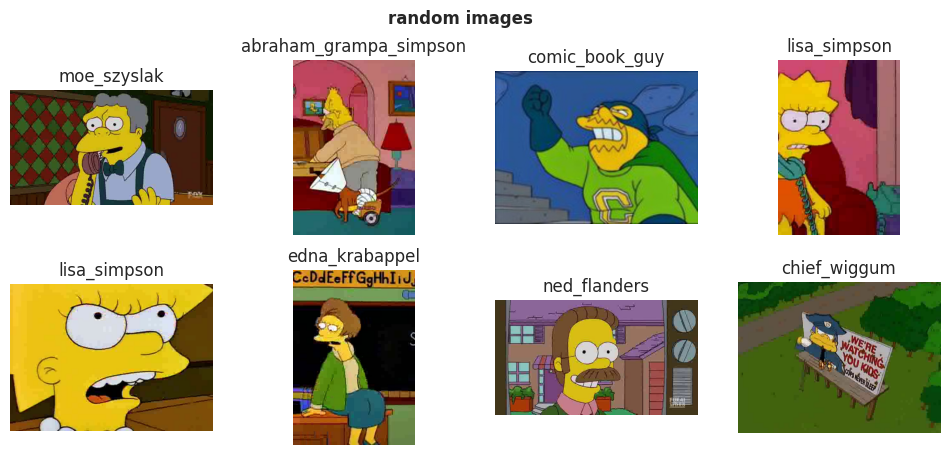

In [11]:
idxs = np.random.randint(len(train_val_files), size=8)

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
fig.suptitle('random images', fontweight='bold')
for ax, idx in zip(axes.flat, idxs):
    img = Image.open(train_val_files[idx])
    label = train_val_files[idx].parent.name
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.show()

Смотрим, как распределены классы в датасете

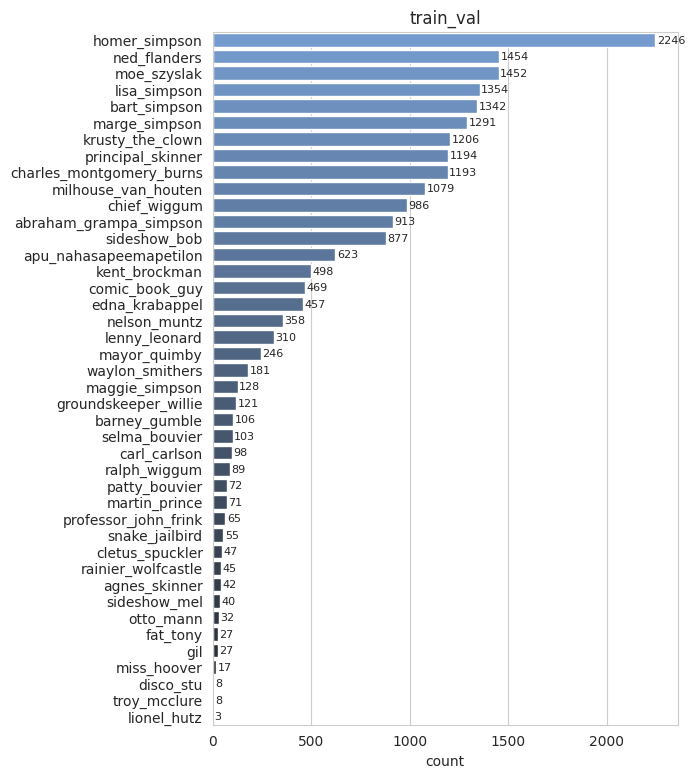

In [12]:
def chart_labels_count(data: list, title=''):
    labels_count = Counter(data)
    labels_count = pd.Series(labels_count).sort_values(ascending=False)
    
    plt.figure(figsize=(6, 9))
    ax = sns.barplot(
        x=labels_count.values,
        y=labels_count.index,
        hue=labels_count.index,
        legend=False,
        palette=sns.dark_palette("#69d", len(labels_count), reverse=True)
    )
    for container in ax.containers:
        ax.bar_label(container, fontsize=8, padding=1)
    plt.title(title)
    plt.xlabel('count')
    plt.ylabel('')
    plt.show()


train_val_labels = [path.parent.name for path in train_val_files]
chart_labels_count(train_val_labels, 'train_val')

Видим, что в данных присутствует дисбаланс классов. Запомнили; постараемся его учесть во время создания DataLoader`а.

Разбиваем размеченную часть датасета на train и val, применяя стратификацию по таргету

In [13]:
train_files, val_files = train_test_split(
    train_val_files,
    test_size=.1,
    stratify=train_val_labels,
    random_state=SEED
)


train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]


data_shape = {
    'train': [len(train_files), len(np.unique(train_labels))],
    'val': [len(val_files), len(np.unique(val_labels))],
    'test': [len(test_files), '-']
}
pd.DataFrame(data_shape, index=['length', 'num_classes']).T

,length,num_classes
train,18839,42
val,2094,41
test,991,-


Формируем словари для перевода названия класса в числовой индекс и обратно

In [14]:
labels_unique = np.unique(train_val_labels)

idx_to_class = {k: v for k, v in enumerate(labels_unique)}
class_to_idx = {v: k for k, v in idx_to_class.items()}

In [15]:
class MakeDataset(Dataset):
    def __init__(self, img_paths, transform=None):
        self.img_paths = img_paths
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)

        label = img_path.parent.name
        if label != 'testset':
            label = class_to_idx[label]
            return img, label
        else:
            return img

Для тренировочного датасета применим случайные аугментации

In [16]:
train_transform = v2.Compose([
    v2.ToImage(), 
    v2.Resize(256),
    v2.RandomRotation(20),
    v2.RandomPerspective(.15),
    v2.ColorJitter(brightness=.1, contrast=.1, saturation=.1, hue=.05),
    # v2.RandomErasing(scale=(0.02, 0.33), ratio=(0.3, 3.3), value='random'),
    # v2.AutoAugment(policy=v2.AutoAugmentPolicy.IMAGENET),
    v2.RandomHorizontalFlip(),
    v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

test_transform = v2.Compose([
    v2.Resize(232),
    v2.CenterCrop(224),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])


train_set = MakeDataset(train_files, transform=train_transform)
val_set = MakeDataset(val_files, transform=test_transform)
test_set = MakeDataset(test_files, transform=test_transform)

Взглянем на примеры картинок после аугментации

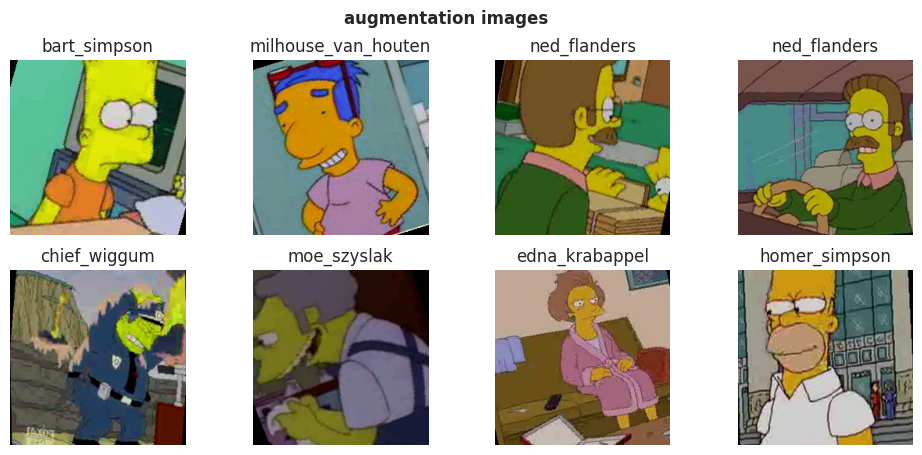

In [17]:
class UnNormalize(v2.Normalize):
    def __init__(self,mean, std, *args, **kwargs):
        new_mean = [-m/s for m, s in zip(mean, std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)


unnorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

idxs = np.random.randint(len(train_set), size=8)

fig, axes = plt.subplots(2, 4, figsize=(12, 5))
fig.suptitle('augmentation images', fontweight='bold')
for ax, idx in zip(axes.flat, idxs):
    img, label = train_set[idx]
    img = unnorm(img).numpy().transpose((1, 2, 0))
    label = idx_to_class[label]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
plt.show()

Для того, чтобы нейронная сеть могла более точно идентифицировать редко встречающиеся изображения, каждый батч мы будем формировать не случайным образом, а с учетом частоты встречаемости конкретного класса. Т.е. редкие классы будут попадать в батч с более высокой вероятностью, что позволит нейронной сети точнее классифицировать объекты минорного класса. Для этого воспользуемся классом **WeightedRandomSampler**.

In [18]:
labels = [path.parent.name for path in train_files]
labels_count = Counter(labels)
weights = {k: 1/v for k, v in labels_count.items()}
sample_weights = [weights[idx] for idx in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights) // 2, replacement=True)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
print('batches in train_loader:', len(train_loader))
print('batches in val_loader:', len(val_loader))
print('batches in test_loader: ', len(test_loader))

print('\nbatch size:', next(iter(train_loader))[0].shape)

batches in train_loader: 589
batches in val_loader: 131
batches in test_loader:  62

batch size: torch.Size([16, 3, 224, 224])


Посмотрим, как распределяются классы после применения **WeightedRandomSampler**

  0%|          | 0/589 [00:00<?, ?it/s]

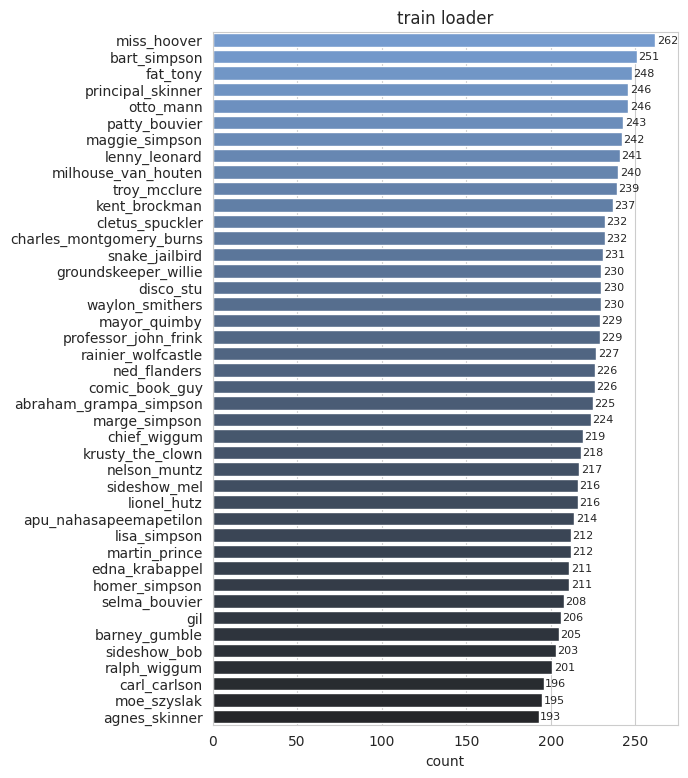

In [20]:
labels_loader = []
for _, labels in tqdm(train_loader):
    labels_loader.extend(labels.tolist())

labels_loader = [idx_to_class[idx] for idx in labels_loader]
chart_labels_count(labels_loader, 'train loader')

Видно, что при таком подходе вероятности выпадения для всех классов из набора примерно равны.

## Model

In [21]:
out_classes = len(idx_to_class)

In [22]:
model = models.resnet50(weights='ResNet50_Weights.IMAGENET1K_V2').to(DEVICE)
model.fc = nn.Linear(2048, out_classes).to(DEVICE)

summary(
    model,
    input_size=tuple(next(iter(train_loader))[0].shape),
    depth=2,
    device=DEVICE,
    col_names=['output_size', 'num_params', 'trainable']
)

/home/lake/anaconda3/envs/lime/lib/python3.9/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:288.)
  return F.linear(input, self.weight, self.bias)


Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
ResNet                                   [16, 42]                  --                        True
├─Conv2d: 1-1                            [16, 64, 112, 112]        9,408                     True
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        128                       True
├─ReLU: 1-3                              [16, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [16, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [16, 256, 56, 56]         --                        True
│    └─Bottleneck: 2-1                   [16, 256, 56, 56]         75,008                    True
│    └─Bottleneck: 2-2                   [16, 256, 56, 56]         70,400                    True
│    └─Bottleneck: 2-3                   [16, 256, 56, 56]         70,400                    True
├─Sequential: 1-6  

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=.85)

metrics = {
    'f1': F1Score(task='multiclass', num_classes=out_classes).to(DEVICE)
}

eval_log = pd.DataFrame()
best_loss = .15

In [24]:
for epoch in range(EPOCHS):
    preds_train = {'loss': [], 'f1':[]}
    preds_val = {'loss': [], 'f1':[]}

    
    # Training
    model.train()
    loop = tqdm(train_loader, leave=False)
    for X, y in loop:
        X, y = X.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(X)
        preds = torch.argmax(outputs, 1)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

        preds_train['loss'].append(loss.item())
        preds_train['f1'].append(metrics['f1'](preds, y).detach().item())
        train_loss = np.mean(preds_train['loss'])
        train_f1 = np.mean(preds_train['f1'])

        loop_description = f"Epoch [{epoch + 1}/{EPOCHS}], train_loss: {train_loss:.4f}, train_f1: {train_f1:.4f}"
        loop.set_description(loop_description)

    
    # Validation
    model.eval()
    with torch.no_grad():
        for X, y in tqdm(val_loader, desc='evaluation', leave=False):
            X, y = X.to(DEVICE), y.to(DEVICE)
            outputs = model(X)
            preds = torch.argmax(outputs, 1)
            loss = criterion(outputs, y)
            
            preds_val['loss'].append(loss.item())
            preds_val['f1'].append(metrics['f1'](preds, y).detach().item())

    val_loss = np.mean(preds_val['loss'])
    val_f1 = np.mean(preds_val['f1'])

    print(f"Epoch [{epoch + 1}/{EPOCHS}], val_loss: {Ansi.bold}{val_loss:.4f}{Ansi.end}, val_f1: {Ansi.bold}{val_f1:.4f}{Ansi.end}", end=' ')

    
    # Scheduler step
    scheduler.step()


    # Save best model
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pt')
        print(f'{Ansi.bold}{Ansi.green}save model{Ansi.end}')


    # Log
    eval_log.loc[epoch+1, 'lr'] = scheduler.get_last_lr()[0]
    eval_log.loc[epoch+1, 'train_loss'] = train_loss
    eval_log.loc[epoch+1, 'train_f1'] = train_f1
    eval_log.loc[epoch+1, 'val_loss'] = val_loss
    eval_log.loc[epoch+1, 'val_f1'] = val_f1

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [1/25], val_loss: 0.3457, val_f1: 0.9164 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [2/25], val_loss: 0.3898, val_f1: 0.9107 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [3/25], val_loss: 0.2138, val_f1: 0.9422 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [4/25], val_loss: 0.1970, val_f1: 0.9556 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [5/25], val_loss: 0.1566, val_f1: 0.9627 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [6/25], val_loss: 0.1291, val_f1: 0.9704 save model


  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [7/25], val_loss: 0.1110, val_f1: 0.9747 save model


  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [8/25], val_loss: 0.1176, val_f1: 0.9695 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [9/25], val_loss: 0.1209, val_f1: 0.9723 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [10/25], val_loss: 0.0917, val_f1: 0.9804 save model


  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [11/25], val_loss: 0.0911, val_f1: 0.9795 save model


  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [12/25], val_loss: 0.0924, val_f1: 0.9819 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [13/25], val_loss: 0.0860, val_f1: 0.9809 save model


  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [14/25], val_loss: 0.0902, val_f1: 0.9813 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [15/25], val_loss: 0.0772, val_f1: 0.9866 save model


  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [16/25], val_loss: 0.0699, val_f1: 0.9847 save model


  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [17/25], val_loss: 0.0765, val_f1: 0.9862 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [18/25], val_loss: 0.0716, val_f1: 0.9857 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [19/25], val_loss: 0.0755, val_f1: 0.9857 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [20/25], val_loss: 0.0826, val_f1: 0.9838 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [21/25], val_loss: 0.0770, val_f1: 0.9857 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [22/25], val_loss: 0.0762, val_f1: 0.9857 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [23/25], val_loss: 0.0776, val_f1: 0.9857 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [24/25], val_loss: 0.0751, val_f1: 0.9857 

  0%|          | 0/589 [00:00<?, ?it/s]

evaluation:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch [25/25], val_loss: 0.0791, val_f1: 0.9843 

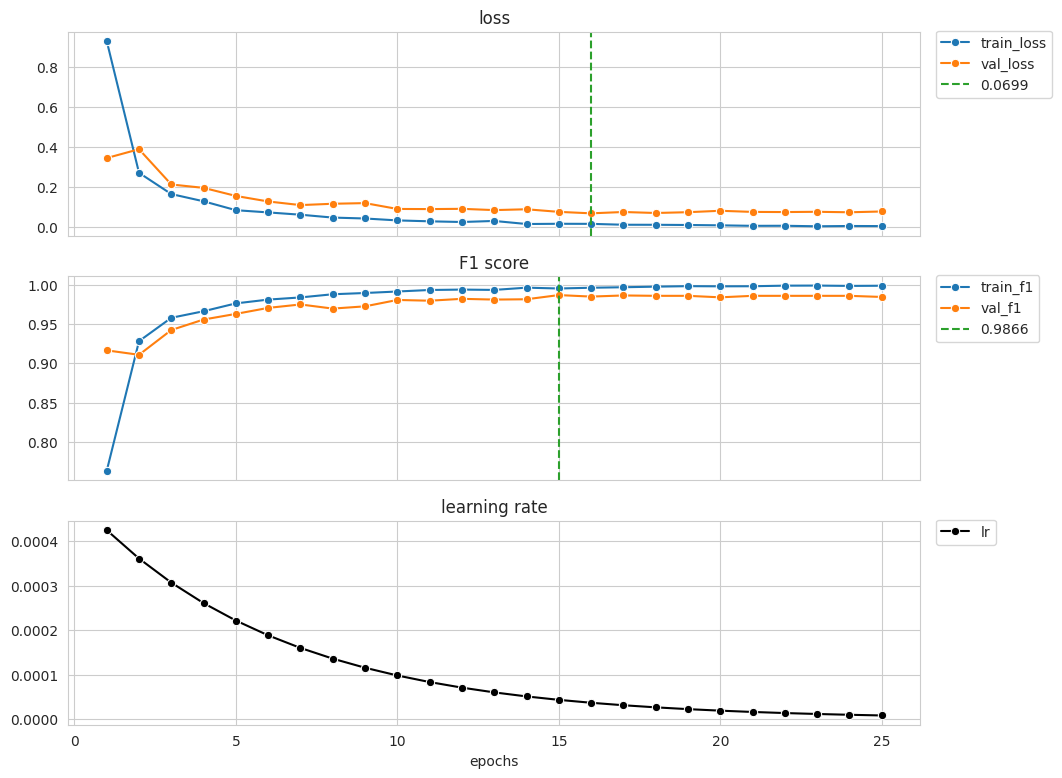

In [25]:
fig, ax = plt.subplots(3, figsize=(11, 9), sharex=True)

sns.lineplot(eval_log[['train_loss', 'val_loss']], dashes=False, markers=['o', 'o'], ax=ax[0])
ax[0].axvline(x=eval_log['val_loss'].idxmin(), color='C2', linestyle='dashed', label=f"{eval_log['val_loss'].min():.4f}")
ax[0].set_title('loss')
ax[0].legend(loc='upper left', bbox_to_anchor=(1.01, 1.04))

sns.lineplot(eval_log[['train_f1', 'val_f1']], dashes=False, markers=['o', 'o'], ax=ax[1])
ax[1].axvline(x=eval_log['val_f1'].idxmax(), color='C2', linestyle='dashed', label=f"{eval_log['val_f1'].max():.4f}")
ax[1].set_title('F1 score')
ax[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.04))

sns.lineplot(eval_log[['lr']], dashes=False, markers='o', ax=ax[2], palette=['black'])
# ax[2].semilogy()
ax[2].set_title('learning rate')
ax[2].set_xlabel('epochs')
ax[2].legend(loc='upper left', bbox_to_anchor=(1.01, 1.04))

plt.show()

## submission

In [26]:
model.load_state_dict(torch.load('best_model.pt'))

/tmp/ipykernel_17124/877896659.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [27]:
predictions = []

model.eval()
with torch.no_grad():
    for X in tqdm(test_loader):
        X = X.to(DEVICE)
        outputs = model(X)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        predictions.extend(preds)

  0%|          | 0/62 [00:00<?, ?it/s]

In [28]:
submission = pd.DataFrame({
    'Id': [file.name for file in test_files],
    'Expected': [idx_to_class[idx] for idx in predictions]
})
submission.to_csv('submission.csv', index=False)
print(f'{Ansi.green}Submission file created{Ansi.end}')

Submission file created


<div align='center'>
    <img src='submission_score.png' alt='submission_score'>
</div>